# Introduction

The context for these problems is that we are trying to understand causality. This causality is understood as a comparison between a set of subjects which have received a specific treatment and a set of sujects that has not received a treatment. The word treatment is commonly used from the medical field, but it can also indicate and specific effect on a group of which we want to measure an outcome. In social sciences, a treatment could be years of college education and the outcome we could be interested in measuring could be a potential the salary increase (see [1]).

The gold standard is of course to carry out an experiment. We would then create a treatment and a control group (or more generally any number of groups) where subjects are randomly assigned to one of the groups. With a sufficiently large number of subjects, the randomness implies that the two groups will have sujects with similar starting characteristics and hence that the groups will not have any bias. This means that after treatment, the comparison of the groups will be fair and that we will in particular be able to measure a treatment effect.

Propensity score weighting is useful in the context of observational studies when experimental studies are not feasible or practical. In this observational case, we need a methodology to select a control group (propensity score matching) or a methodology to remove the bias between treated and untreated subjects (propensity score weighting).

But propensity score weighting is also useful in randomized studies to correct for potential imbalances, handling missing data, reducing variance and studying subgroups.


# Fundamental ideas

Let's take a look at the formulation of the problem, the assumptions and how propensity weighting works.

## Formulation

We are interested in quantifying the average treatment effect which is the difference between the expectation of the subjects that are treated and the expectation of the subjects that are not treated:
\begin{align}
\underbrace{\mathbb{E}\left[Y_i \mid T_i=1\right] - \mathbb{E}\left[Y_i \mid T_i=0\right]}_{\text{Average treatment effect}} 
&=\mathbb{E}\left[Y_{1i} \mid T_i=1\right] - \mathbb{E}\left[Y_{0i} \mid T_i=0\right] \\
&=\mathbb{E}\left[Y_{1i} \mid T_i=1\right] - \mathbb{E}\left[Y_{0i} \mid T_i=1\right] + \mathbb{E}\left[Y_{0i} \mid T_i=1\right] - \mathbb{E}\left[Y_{0i} \mid T_i=0\right] \\[10pt]
&=\underbrace{\mathbb{E}\left[Y_{1i} - Y_{0i} \mid T_i=1\right]}_{\text{Average treatment effect on the treated}} 
+ \underbrace{\mathbb{E}\left[Y_{0i} \mid T_i=1\right] - \mathbb{E}\left[Y_{0i} \mid T_i=0\right]}_{\text{Selection bias}}
\end{align}

Note the distinction between $Y_{0i}$ and $Y_{1i}$ and the outcome $Y_i$. Indeed, $Y_i$ can only ever take one of the two values, because each subject either receives the treatment or it doesn't. So one of these is always the counterfactual. This is the mathematical expression:

$$ Y_i = T \cdot Y_{1i} + (1 - T) \cdot Y_{0i} $$

Obviously we want to remove the selection bias, and together with a certain number of assumptions, propensity weighting methodologies will help us achieve this goal by, among other things, weighting observations in the treatment and control group.

## Conditional independence assumption (CIA)

The conditional independence assumption (CIA) also referred to as Strong Ignorability or Unconfoundedness, is is given by

$$ Y_{0i}, Y_{1i} \perp \!\!\!\perp T_i \mid \underline{X_i} $$

This is the assumption that the outcomes $Y_{0i}$ and $Y_{1i}$ are independent from the group T (treatment or control) conditional on the covariates $X$.

It's easier to grasp what the CIA is saying with a small example. Let's imagine that we are interested in the mean weight of a population composed of females and males gorillas. Let's further suppose that there is a treatment group and a control group (although in this example we do not apply a treatment). The treatment group is composed of 25% males and 75% females, whereas the control group is the opposite. In our example the mean weight for males is  374 lbs whereas the mean weight for females is 158 lbs (data for Western Lowland gorillas sourced [here](https://seaworld.org/animals/all-about/gorilla/characteristics/)). Clearly the mean weights $Y_{i0}$ and $Y_{1i}$ are not independent from the treatment assigment $T$. But they are independent conditional on gender covariate $X$ if the female weight and the male weight has the same mean in both groups, because there is no information we can obtain about the treatment $T_i$ if one considers separately the male and female weights.

But, as we will see later, if we omit a conditional variable we are at risk again of losing the independence. This would be the case for instance if the control group was not anymore formed only by Western Lowland gorillas, but instead contained a proportion of Eastern Lowland gorillas which are heavier and have mean weights of 484 lbs and 176 lbs for males and females respectively. We could of course, if we knew that we had different types of gorillas in our sample, extend the covariate vector $\underline{X}$ to contain both weight and gorilla type.


## Why the CIA matters

The CIA matters because if the assignment to a treatment group is not independent given the covariates, there is no way to determine if a change in the outcome in the treatment group is the effect of the treatment or if it is due to a conditional dependence. In the gorillas example, if for instance the treatment consisted of a different diet, we would not know if the difference in weight observed between the treatment and control groups was due to the diet or to the (unknown) presence of Lowland gorillas in the treatment group.

## Propensity theorem

We define the propensity $e(\underline{X})$ as the probability based on the information in $\underline{X}$ of belonging to the treatment group. We will see later that this probability can be estimated for example via logistic or gradient boosted trees regression. The definition of the propensity is then:

$$e(X_i) = \mathbb{E}[T_i \mid \underline{X_i}]$$

Then under the CIA the following holds

$$ Y_{0i}, Y_{1i} \perp \!\!\!\perp T_i \mid e(\underline{X_i}) $$

that is, the propensity is also conditionally independent.

Furthermore, the propensity $e(\underline{X})$ can be used to estimate the average treatment effect in the same way as the vector as covariates $\underline{X}$.  

The reason this theorem is important is that the propensity $e(\underline{X})$ is a scalar and makes the computation of the average treatment effect tractable.

For some intuition behind the equivalence, what we need to show is that $P\left[T_i=1 \mid Y_{ji}, e(X_i)\right]$ does not depends on $Y_{ji}$ :

\begin{align}
P\left[T_i=1 \mid Y_{ji}, e(X_i)\right] &=  \mathbb{E}\left[T_i \mid Y_{ji}, e(\underline{X_i})\right] \\
&=\mathbb{E}\left[\mathbb{E}\left[T_i \mid Y_{ji}, e(\underline{X_i}), \underline{X_i}\right] \mid Y_{ji}, e(\underline{X_i}) \right] \\
&=\mathbb{E}\left[\mathbb{E}\left[T_i \mid \underline{X_i}\right] \mid Y_{ij}, e(\underline{X_i}) \right] \quad\quad \text{(using CIA)} \\
&=\mathbb{E}\left[e(\underline{X_i}) \mid Y_{ji}, e(X_i) \right] \\
&=e(\underline{X_i})
\end{align}


## Propensity weighting

The last piece of the puzzle is the balancing of the treatment and control group which is given by:

$$ \mathbb{E}\left[Y_{1i} - Y_{0i}\right] = \mathbb{E}\left[\frac{Y_i D_i}{e(\underline{X_i})} - \frac{Y_i (1 - D_i)}{1 - e(\underline{X_i})}\right]$$

A proof of the equivalence of $\mathbb{E}\left[Y_{1i}\right]$ and $\mathbb{E}\left[\frac{Y_i D_i}{e(\underline{X_i})}\right]$:

\begin{align}
\mathbb{E}\left[\frac{Y_i T_i}{e(\underline{X_i})}\right] &= \mathbb{E}\left[\mathbb{E}\left[\frac{Y_i T_i}{e(\underline{X_i})} \mid \underline{X_i}\right]\right] \\
&=\mathbb{E}\left[\frac{\mathbb{E}\left[Y_i T_i\mid \underline{X_i}\right]}{e(\underline{X_i}) }\right]    \quad\quad \text{(using CIA)} \\
&=\mathbb{E}\left[\frac{\mathbb{E}\left[Y_{1i} \mid \underline{X_i}, T=1\right] \cdot P(T_i=1 \mid \underline{X_i})}{P(T_i=1 \mid \underline{X_i})}\right] \\
&=\mathbb{E}\left[ \mathbb{E}\left[Y_{1i} \mid \underline{X_i}\right] \right] \\
&=\mathbb{E}\left[Y_{1i}\right]
\end{align}

So we see that, under the conditional independence assumption the average treatment effect (ATE) can be estimated from inverse propensity weighted observations.

One last piece of the puzzle is that this weighting is not unique. Depending on what we wish to measure, we can choose different weights. A summary can be found in LLL, but we reproduce here the first three:

| Target population | Tilt function | Estimand     | Balancing Weights |
|-------------------|---------------|--------------|-------------------|
| Treatment and control combined | 1                    | ATE     | $(\frac{1}{e(X)}, \frac{1}{1 - e(X)})$ |
| Treatment                      |  $e(X)$            | ATT     | $(1, \frac{e(X)}{1 - e(X)})$           |
| Overlap                        |  $e(X) (1-e(X))$ | ATO     | $(1 - e(X), e(X))$                     |

A first reason for the choice of the target population is of course what the purpose of the study. If for instance the treatment was interventional and we wanted to quantify the intervention, then we'd be interested in the target population, i.e. the ATT. Or we might be interested in the benefit of treating the whole population in which case the ATE would be of interest.

But if populations are very different, it becomes more difficult to compare the two populations fairly and the overlap population might be appropriate. When the populations differ a lot, the overlap will also be more stable and yield a smaller variance. 

Finally, another option is to trim to get rid of the more extreme weights. A trim value (delta) of 0.2 is shown to often be optimal (see LLL).

## A very simple example

Let's imagine we have small green balls of weight 2 and large red balls of weight 3; DALL-E is able to imagine this quite well:

![green_and_read_balls](./img/red_green_balls.png)

Let's say we observe 3 balls in a treatment group (T=1) and 3 ball in a control group (T=0); X is the color and the Y weight:

| Y | X | T | $e(X)$| $1-e(X)$| $\frac{Y_i T_i}{e(X_i)}$ | $\frac{Y_i (1-T_i)}{1-e(X_i)}$ |
|---|---|---|-------------|---|---|---|
|3  |Red| 1 | 2/3         |1/3| 4.5  | 0  |
|3  |Red| 1 | 2/3         |1/3| 4.5  | 0  |
|2  |Green| 1 | 1/3       |2/3| 6  | 0  |
|2  |Green| 0 | 1/3       |2/3| 0  | 3  |
|2  |Green| 0 | 1/3       |2/3| 0  | 3  |
|3  |Red| 0 | 2/3         |1/3| 0  | 9  |

Now, let's calculate $ \mathbb{E}\left[Y_{1i}\right]$ and $ \mathbb{E}\left[Y_{0i}\right]$:

$$ \mathbb{E}\left[Y_{1i}\right] ≈ \frac{4.5 + 4.5 + 6 }{6} = \frac{5}{2} $$

$$ \mathbb{E}\left[Y_{0i}\right] ≈ \frac{3 + 3 + 9 }{6} = \frac{5}{2} $$

In this case there is no treatment and no variability in Y conditional on X, so the two means are as expected the same.

# Slightly more complex examples

In this section we still use simple examples but this time we generate some random data to show how things work in practice.

## A simple univariate case

Let's imagine we have patients that have been prescribed a medication. Let's assume these patients are part of two geographical areas, Boston and Chicago. Patients in Boston have a probability of filling this prescription 0.7 whereas patients in Chicago have a probability of filling this prescription of 0.6. We will form a treatment and control group and the treatment will consist of sending a message with medical information about the medication. The effect of this treatment will be to increase the probability of filling by 0.1.

In [1]:
library(data.table)
library(PSweight)
library(ggplot2)
library(MASS)   # for multivariate normal generation

In [2]:
N <- 500      ## nb of patients in each group
p_boston <- 0.7
p_chicago <- 0.5
treatment_effect <- 0.1

### Random assignment

In this first case we have a random assigment between the groups.

In [3]:
# smokers have mean 60 days recovery, non-smokers 30 days
set.seed(0)
ex1 <- rbind(data.table(region=sample(c("Chicago", "Boston"), size=N, replace=TRUE, prob=c(0.8, 0.2)),
                        T=TRUE),
             data.table(region=sample(c("Chicago", "Boston"), size=N, replace=TRUE, prob=c(0.5, 0.5)),
                        T=FALSE))
ex1[, p := ifelse(region=="Chicago", p_chicago, p_boston)]
ex1[T==TRUE, p := p + treatment_effect]
ex1[, Y := rbinom(1, 1, p), by=1:(2*N)]
head(ex1)

region,T,p,Y
<chr>,<lgl>,<dbl>,<int>
Boston,TRUE,0.8,1
Chicago,TRUE,0.6,1
Chicago,TRUE,0.6,0
Chicago,TRUE,0.6,1
Boston,TRUE,0.8,0
Chicago,TRUE,0.6,1


In [4]:
logistic_model <- glm("T ~ region", family=binomial, data=ex1)
summary(logistic_model)


Call:
glm(formula = "T ~ region", family = binomial, data = ex1)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.38683  -0.95136   0.08766   0.98152   1.60131  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -0.9571     0.1201  -7.971 1.57e-15 ***
regionChicago   1.4371     0.1445   9.942  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1386.3  on 999  degrees of freedom
Residual deviance: 1278.7  on 998  degrees of freedom
AIC: 1282.7

Number of Fisher Scoring iterations: 4


In [5]:
## get the probabilities of belonging to the treatment group, the propensity:
ex1[, propensity := predict(logistic_model, ex1[, .(region)], type="response")]
print(ex1, topn=10)

Index: <T>
       region      T     p     Y propensity
       <char> <lgcl> <num> <int>      <num>
   1:  Boston   TRUE   0.8     1  0.2774566
   2: Chicago   TRUE   0.6     1  0.6177370
   3: Chicago   TRUE   0.6     0  0.6177370
   4: Chicago   TRUE   0.6     1  0.6177370
   5:  Boston   TRUE   0.8     0  0.2774566
   6: Chicago   TRUE   0.6     1  0.6177370
   7:  Boston   TRUE   0.8     1  0.2774566
   8:  Boston   TRUE   0.8     1  0.2774566
   9: Chicago   TRUE   0.6     1  0.6177370
  10: Chicago   TRUE   0.6     0  0.6177370
  ---                                      
 991: Chicago  FALSE   0.5     1  0.6177370
 992:  Boston  FALSE   0.7     1  0.2774566
 993:  Boston  FALSE   0.7     1  0.2774566
 994: Chicago  FALSE   0.5     0  0.6177370
 995:  Boston  FALSE   0.7     0  0.2774566
 996:  Boston  FALSE   0.7     1  0.2774566
 997: Chicago  FALSE   0.5     1  0.6177370
 998: Chicago  FALSE   0.5     0  0.6177370
 999:  Boston  FALSE   0.7     1  0.2774566
1000:  Boston  FALSE 

In [6]:
## now calculate the weights:
ex1[T==TRUE, weight := 1 / propensity]
ex1[T==FALSE, weight := 1 / (1 - propensity)]
print(ex1, topn=10)

Index: <T>
       region      T     p     Y propensity   weight
       <char> <lgcl> <num> <int>      <num>    <num>
   1:  Boston   TRUE   0.8     1  0.2774566 3.604167
   2: Chicago   TRUE   0.6     1  0.6177370 1.618812
   3: Chicago   TRUE   0.6     0  0.6177370 1.618812
   4: Chicago   TRUE   0.6     1  0.6177370 1.618812
   5:  Boston   TRUE   0.8     0  0.2774566 3.604167
   6: Chicago   TRUE   0.6     1  0.6177370 1.618812
   7:  Boston   TRUE   0.8     1  0.2774566 3.604167
   8:  Boston   TRUE   0.8     1  0.2774566 3.604167
   9: Chicago   TRUE   0.6     1  0.6177370 1.618812
  10: Chicago   TRUE   0.6     0  0.6177370 1.618812
  ---                                               
 991: Chicago  FALSE   0.5     1  0.6177370 2.616000
 992:  Boston  FALSE   0.7     1  0.2774566 1.384000
 993:  Boston  FALSE   0.7     1  0.2774566 1.384000
 994: Chicago  FALSE   0.5     0  0.6177370 2.616000
 995:  Boston  FALSE   0.7     0  0.2774566 1.384000
 996:  Boston  FALSE   0.7     1  0

Here are the unweighted means of the two groups:

In [7]:
mu1_unweighted <- sum(ex1[T==TRUE ]$Y) / nrow(ex1[T==TRUE])
mu0_unweighted <- sum(ex1[T==FALSE]$Y) / nrow(ex1[T==FALSE])
cat(paste("treatment group unweighted mean:", mu1_unweighted, "\n"))
cat(paste("control group unweighted mean:", mu0_unweighted, "\n"))
cat(paste("average treatment effect:", mu1_unweighted - mu0_unweighted, "\n"))

treatment group unweighted mean: 0.642 
control group unweighted mean: 0.62 
average treatment effect: 0.022 


Here is the weighted means of the two groups:

In [8]:
mu1_weighted <- sum(ex1$Y * ex1$weight * ex1$T) / sum(ex1$T * ex1$weight)
mu0_weighted <- sum(ex1$Y * ex1$weight * (1-ex1$T)) / sum((1 - ex1$T) * ex1$weight) 
cat(paste("treatment group weighted mean:", mu0_weighted, "\n"))
cat(paste("control group weighted mean:", mu1_weighted, "\n"))

treatment group weighted mean: 0.590432000000028 
control group weighted mean: 0.682437706270525 


### Checking with PSweight

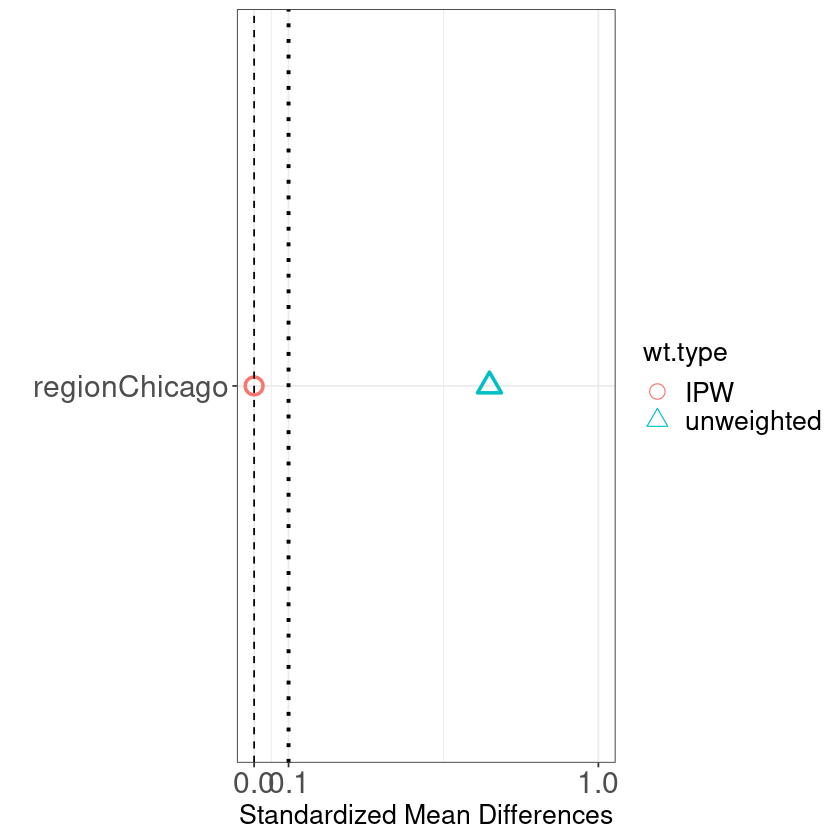

In [9]:
options(jupyter.plot_scale=1.5)
ipw_ss <- SumStat(T ~ region, data=ex1, weight="IPW")
plot(ipw_ss)

In [10]:
ipw <- PSweight(T ~ region, data=ex1, yname="Y", weight="IPW")
print(summary(ipw))
ipw


Closed-form inference: 

Original group value:  FALSE, TRUE 

Contrast: 
           FALSE TRUE
Contrast 1    -1    1

           Estimate Std.Error      lwr     upr Pr(>|z|)   
Contrast 1 0.092006  0.030600 0.032031 0.15198 0.002641 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Original group value:  FALSE, TRUE 

Point estimate: 
0.5904, 0.6824 

## Multivariate case with interaction

Here is a multivariate example with an interaction between the covariates. This example makes the case for fitting using a gradient boosted model rather than a GLM.

Here `c1` and `c2` are two boolean variables that interact together: when they are both the same, that is (T, T) or (F, F) we set the mean of 'y' higher; when they are opposite, that
is (T,F), (F,T), the mean of 'y' is set lower. In each individual column 'c1' and 'c2', we have equal probability of T, but for (c1,c2) combined, different probabilities of (T,T) in the treatment
and control groups.

This allows to show that for the 'gbm' method, the 'interaction.depth' (and any other 'gbm' control parameter) is not
taken into account in the current implementation. So unless the
interaction is explicitly entered in the formula, 'gbm' will not
discover the interaction and 'PSweight' will incorrectly conclude
that the means differ. In the fixed implementation, these
parameters are taken into account and the means do not differ.

In [11]:
N <- 1000                               # the number of obs in each group

set.seed(0)
## function to generate (T,T) and (F,F) pairs
generate_tt_ff <- function(n) {
    c1 <- rbinom(n, 1, 0.5)
    data.table(c1, c2=c1)
}

## function to generate (T,F) and (F,T) pairs
generate_tf_ft <- function(n) {
    c1 <- rbinom(n, 1, 0.5)
    data.table(c1, c2=!c1)
}

## the probability of having (T,T), (F,F) is 0.8 in the treatment group:
p_tt_ff_treatment <- 0.8                
treatment <- rbind(generate_tt_ff(p_tt_ff_treatment * N),
                   generate_tf_ft((1 - p_tt_ff_treatment) * N))
## and 0.2 in the control group:
control <- rbind(generate_tf_ft(p_tt_ff_treatment * N),
                 generate_tt_ff((1 - p_tt_ff_treatment) * N))

dt <- rbind(data.table(treatment, treatment=TRUE),
            data.table(control, treatment=FALSE))

## construct 'y' conditional on 'c1' and 'c2':
y <- rnorm(nrow(dt), 2, 1)
idx_tt_ff <- which(!xor(dt$c1, dt$c2))
y[idx_tt_ff] <- rnorm(length(idx_tt_ff), 4, 1)
dt$y <- y
dt

c1,c2,treatment,y
<int>,<int>,<lgl>,<dbl>
1,1,TRUE,5.150781
0,0,TRUE,3.157955
0,0,TRUE,3.138722
1,1,TRUE,3.461936
1,1,TRUE,4.496595
0,0,TRUE,2.558034
1,1,TRUE,2.887398
1,1,TRUE,2.985451
1,1,TRUE,4.567364


We see that we have the same proportions for c1/c2 in both treatment and control group:

In [12]:
summary(dt[treatment==TRUE])
summary(dt[treatment==FALSE])

       c1               c2         treatment            y         
 Min.   :0.0000   Min.   :0.0000   Mode:logical   Min.   :-1.045  
 1st Qu.:0.0000   1st Qu.:0.0000   TRUE:999       1st Qu.: 2.883  
 Median :0.0000   Median :0.0000                  Median : 3.703  
 Mean   :0.4815   Mean   :0.4985                  Mean   : 3.604  
 3rd Qu.:1.0000   3rd Qu.:1.0000                  3rd Qu.: 4.513  
 Max.   :1.0000   Max.   :1.0000                  Max.   : 6.783  

       c1               c2         treatment             y         
 Min.   :0.0000   Min.   :0.0000   Mode :logical   Min.   :-1.037  
 1st Qu.:0.0000   1st Qu.:0.0000   FALSE:999       1st Qu.: 1.631  
 Median :0.0000   Median :1.0000                   Median : 2.364  
 Mean   :0.4805   Mean   :0.5185                   Mean   : 2.458  
 3rd Qu.:1.0000   3rd Qu.:1.0000                   3rd Qu.: 3.217  
 Max.   :1.0000   Max.   :1.0000                   Max.   : 6.601  

In [13]:
## now fit two models, p1 with the default 'gbm' parameters that will
## have 'interaction.depth' set to 1 as default and will thus not be
## able to learn the interaction between 'c1' and 'c2'.
set.seed(0)
p1 <- PSweight(treatment ~ c1 + c2, yname="y", data=dt, ps.method="gbm")
p1

Original group value:  FALSE, TRUE 

Point estimate: 
2.4571, 3.6026 

In [14]:
## and 'p2' with 'interaction.depth' set to 2, that will learn
## correctly and allow the method to correctly conclude that the means
## are the same:
set.seed(0)
p2 <- PSweight(treatment ~ c1 + c2, yname="y", data=dt, ps.method="gbm",
               ps.control=list(interaction.depth=2))
p2

Original group value:  FALSE, TRUE 

Point estimate: 
3.0164, 2.9907 

In [15]:
head(p1$propensity)
head(p2$propensity)

FALSE,TRUE
0.5122574,0.4877426
0.4941118,0.5058882
0.4941118,0.5058882
0.5122574,0.4877426
0.5122574,0.4877426
0.4941118,0.5058882


FALSE,TRUE
0.2066791,0.7933209
0.2001336,0.7998664
0.2001336,0.7998664
0.2066791,0.7933209
0.2066791,0.7933209
0.2001336,0.7998664


## Problems

### Missing propensity variable

### Small divisors

We introduce a new covariate `new_surgery`. In the test group, we assign all smokers to new_surgery and all non-smokers to non-new_surgerys; in the control group, we assign the new_surgerys randomly to the whole population with the same probability as the probability of being smoker in the control group (0.75).

In [16]:
ex2 <- copy(ex1)
ex2[test==TRUE, new_surgery := smoker]
#ex2[test & smoker, new_surgery := rbinom(nrow(ex2[test & smoker]), 1, 0.9)]
#ex2[test & !smoker, new_surgery := rbinom(nrow(ex2[test & !smoker]), 1, 0.1)]
ex2[test==FALSE, new_surgery := rbinom(nrow(ex2[test==FALSE]), 1, p_s)]

ERROR: Error: Object 'test' not found amongst [region, T, p, Y, propensity, weight]


In [ ]:
## percent smoker new_surgerys:
nrow(ex2[test & smoker & new_surgery])/nrow(ex2[test & smoker])

In [ ]:
## percent male new_surgerys:
nrow(ex2[test & !smoker & new_surgery])/nrow(ex2[test & !smoker])

In [ ]:
logistic_model <- glm("test ~ smoker + new_surgery", family=binomial, data=ex2)
summary(logistic_model)

In [ ]:
ex2[, propensity := predict(logistic_model, ex2, type="response")]
ex2[test==TRUE, weight := 1 / propensity]
ex2[test==FALSE, weight := 1 / (1 - propensity)]
print(ex2, topn=10)

In [ ]:
summary(aov(recovery ~ test, data=ex2))

In [ ]:
summary(aov(recovery ~ test, data=ex2, weights=ex2$weight))

In [ ]:
print(sum(ex2[test==TRUE]$smoker)/nrow(ex2[test==TRUE]))
print(sum(ex2[test==FALSE]$smoker)/nrow(ex2[test==FALSE]))
print(sum(ex2[test &  smoker]$weight)/sum(ex2[test==TRUE]$weight))
print(sum(ex2[!test & smoker]$weight)/sum(ex2[test==FALSE]$weight))

In [ ]:
print(sum(ex2[test==TRUE]$new_surgery)/nrow(ex2[test==TRUE]))
print(sum(ex2[test==FALSE]$new_surgery)/nrow(ex2[test==FALSE]))
print(sum(ex2[test &  new_surgery]$weight)/sum(ex2[test==TRUE]$weight))
print(sum(ex2[!test & new_surgery]$weight)/sum(ex2[test==FALSE]$weight))

Now let's imagine new_surgery has an effect, if you're a new_surgery, you're 15 recovery lighter:

In [ ]:
ex2[new_surgery==TRUE, recovery := recovery + 50]

In [ ]:
summary(aov(recovery ~ test, data=ex2))

We find then with these weights that the test group is significantly different from the control group, which we know by design of this simulation is not true:

In [ ]:
summary(aov(recovery ~ test, data=ex2, weights=ex2$weight))

### Running PSweight

In [ ]:
ipw <- PSweight(test ~ smoker + new_surgery, data=ex2, yname="recovery", weight="IPW")
print(ipw)
summary(ipw)

In [ ]:
ipw_ss <- SumStat(test ~ smoker + new_surgery, data=ex2, weight="IPW")
summary(ipw_ss)

In [ ]:
plot(ipw_ss)

In [ ]:
aipw <- PSweight(test ~ smoker + new_surgery, data=ex2, yname="recovery", weight="IPW", 
                augmentation = TRUE, out.formula = recovery ~ smoker + new_surgery)
summary(ipw)

# AIPW

Let's examine the Augmented Inverse Propensity Weighting. We start by simulating a simple treatment/control group with a couple of covariates.

$$Y_{i} \sim X_{i}\beta + W_{i}\tau + \epsilon$$

To add some realism, we'll have our treatment have a different range of X and fix $\beta$ and $\tau$.

$$X_{treat} \sim Normal(\mu=4, \sigma=1)$$
$$X_{cntl} \sim Normal(\mu=6, \sigma=1)$$
$$\beta = 2$$
$$\tau = 1$$
$$\epsilon \sim Normal(\mu=0.1, \sigma=1)$$

In [17]:
set.seed(0)
sz <- 2500
beta1 <- 2
tau <- 1
mu_epsilon <- 0.1
dt <- data.table(x1=c(rnorm(sz, 4, 1), rnorm(sz, 6, 1)), 
                 W=c(rep(1, sz), rep(0, sz)),
                 epsilon=rnorm(sz*2, mu_epsilon, 1))
dt[, y := x1 * beta1 + W * tau + epsilon]
print(summary(dt[W==1]))
print(summary(dt[W==0]))

       x1               W        epsilon              y         
 Min.   :0.7636   Min.   :1   Min.   :-3.0884   Min.   : 1.783  
 1st Qu.:3.3042   1st Qu.:1   1st Qu.:-0.5677   1st Qu.: 7.595  
 Median :3.9824   Median :1   Median : 0.1165   Median : 9.068  
 Mean   :3.9941   Mean   :1   Mean   : 0.1049   Mean   : 9.093  
 3rd Qu.:4.7024   3rd Qu.:1   3rd Qu.: 0.7653   3rd Qu.:10.647  
 Max.   :7.2664   Max.   :1   Max.   : 3.6681   Max.   :16.590  
       x1              W        epsilon              y         
 Min.   :2.297   Min.   :0   Min.   :-3.3593   Min.   : 4.552  
 1st Qu.:5.360   1st Qu.:0   1st Qu.:-0.6009   1st Qu.:10.675  
 Median :6.015   Median :0   Median : 0.1319   Median :12.130  
 Mean   :6.020   Mean   :0   Mean   : 0.1232   Mean   :12.162  
 3rd Qu.:6.677   3rd Qu.:0   3rd Qu.: 0.8067   3rd Qu.:13.664  
 Max.   :8.922   Max.   :0   Max.   : 3.4768   Max.   :19.044  


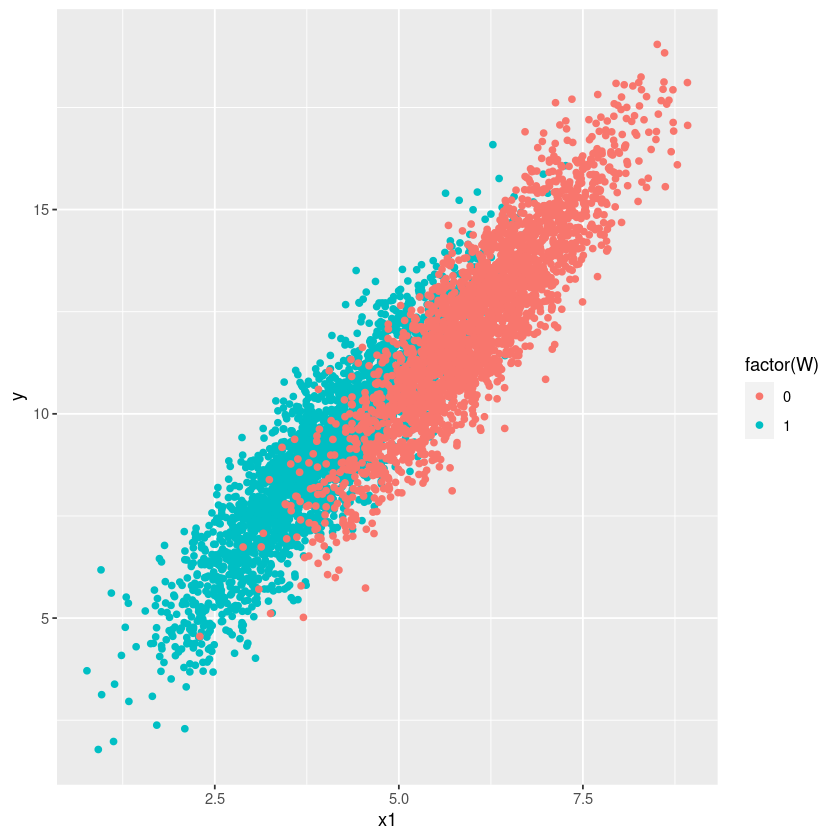

In [18]:
ggplot(dt, aes(x1, y, color=factor(W))) +
    geom_point()

## IPW

First we use a logistic regression to figure out the propensity score $e_i$:

In [19]:
propensity_model <- glm(W ~ x1, data=dt, family=binomial)
summary(propensity_model)


Call:
glm(formula = W ~ x1, family = binomial, data = dt)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3240  -0.5003  -0.0041   0.4795   3.0202  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  10.1749     0.2833   35.92   <2e-16 ***
x1           -2.0265     0.0556  -36.44   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 6931.5  on 4999  degrees of freedom
Residual deviance: 3499.9  on 4998  degrees of freedom
AIC: 3503.9

Number of Fisher Scoring iterations: 6


In [20]:
dt[, e := predict(propensity_model, data=dt, type="response")]
print(dt)

Index: <W>
            x1     W    epsilon        y           e
         <num> <num>      <num>    <num>       <num>
   1: 5.262954     1  0.4925581 12.01847 0.379829337
   2: 3.673767     1  0.5582467  8.90578 0.938782155
   3: 5.329799     1 -1.1196454 10.53995 0.348479148
   4: 5.272429     1 -1.0220983 10.52276 0.375316981
   5: 4.414641     1  1.0933303 10.92261 0.773607642
  ---                                               
4996: 7.863367     0  0.3136543 16.04039 0.003141551
4997: 8.162363     0  0.8330922 17.15782 0.001716424
4998: 7.175956     0  0.8570839 15.20900 0.012531669
4999: 6.619077     0  0.8986270 14.13678 0.037746158
5000: 6.008463     0  0.0443967 12.06132 0.119096601


And now we can estimate the propensity weighted means and see what $\tau$ we get:

In [21]:
mu1 <- sum(dt$W * dt$y / dt$e) / sum(dt$W / dt$e)
mu0 <- sum((1-dt$W) * dt$y / (1-dt$e)) / sum((1 - dt$W) / (1 - dt$e))
cat(paste("mu1:", mu1, "\n"))
cat(paste("mu0:", mu0, "\n"))
ATE_prop <- mu1 - mu0
print(ATE_prop)

mu1: 10.8842605617515 
mu0: 10.271564796472 
[1] 0.6126958


## Regression

Now let's look at a second way of approching the problem. Here we estimate directly $\mu_{0}$
and $\mu_{1}$ from the treatment and control groups, conditional on X.

Note the regression is conducted separately on the two groups. It is not:

$$Y \sim X\beta + W\tau + \epsilon$$

but instead:

$$Y_{1} \sim X_{1}\beta_{1} + \epsilon$$
$$Y_{0} \sim X_{0}\beta_{0} + \epsilon$$

One explanation of the serparate regression:

"We emphasize that, throughout our analysis, we defined the target estimand τ = E [∆i] before making any modeling assumptions. Linear modeling was only used as a tool to estimate τ , but did not inform the scientific question we tried to answer. In particular, we did not try to estimate τ by direct regression modeling $Y_{i} \sim X_{i}\beta + W_{i}\tau + \epsilon_{i}$, while claiming that the coefficient on τ is a causal effect. This approach has the vice of tying our scientific question to our regression modeling strategy: τ appears to just have become a coefficient in our linear model, not a fact of nature that’s conceptually prior to modeling decisions." (https://web.stanford.edu/~swager/stats361.pdf, page 8).

But another less philosophical is that one cannot make the assumption that both the treatment group and the control group have the exact same relationship between covariates and outcome.

In [22]:
model_mu1 <- lm(y ~ x1, data=dt[W==1])
summary(model_mu1)


Call:
lm(formula = y ~ x1, data = dt[W == 1])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1967 -0.6734  0.0109  0.6597  3.5647 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.11934    0.08020   13.96   <2e-16 ***
x1           1.99639    0.01946  102.57   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9846 on 2498 degrees of freedom
Multiple R-squared:  0.8081,	Adjusted R-squared:  0.808 
F-statistic: 1.052e+04 on 1 and 2498 DF,  p-value: < 2.2e-16


In [23]:
model_mu0 <- lm(y ~ x1, data=dt[W==0])
summary(model_mu0)


Call:
lm(formula = y ~ x1, data = dt[W == 0])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4456 -0.7236  0.0143  0.6865  3.3276 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.10244    0.12589  -0.814    0.416    
x1           2.03749    0.02064  98.705   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.01 on 2498 degrees of freedom
Multiple R-squared:  0.7959,	Adjusted R-squared:  0.7958 
F-statistic:  9743 on 1 and 2498 DF,  p-value: < 2.2e-16


Now we've got our models for $\mu_{1}$, $\mu_{0}$, we evaluate them conditional on all X:

In [24]:
ATE_reg <- 1/nrow(dt) * sum(predict(model_mu1, dt) - predict(model_mu0, dt))
ATE_reg

[1] 1.016012

Note that in this case we have the same generating process, so the combined regression gives a similar results for the ATE:

In [25]:
model_t <- lm(y ~ x1 + W, data=dt)
summary(model_t)


Call:
lm(formula = y ~ x1 + W, data = dt)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4586 -0.6994  0.0146  0.6739  3.5563 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.02542    0.08762    0.29    0.772    
x1           2.01625    0.01417  142.26   <2e-16 ***
W            1.01461    0.04025   25.21   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9973 on 4997 degrees of freedom
Multiple R-squared:  0.8652,	Adjusted R-squared:  0.8652 
F-statistic: 1.604e+04 on 2 and 4997 DF,  p-value: < 2.2e-16


## IPW + regression = AIPW

We now use both the IPW and the regression to get the Augmented IPW; for this, the idea is to calculate $\mu_0$ and $\mu_1$, and then to use the IPW on the residuals of the regression instead of directly on the Y.

$$\tau_{\text{AIPW}} = \frac{1}{n} \sum_{i=1}^{n} \left( \hat{\mu}(1)(X_i) - \hat{\mu}(0)(X_i) + \frac{T_i(Y_i - \hat{\mu}(1)(X_i))}{\hat{e}(X_i)} - \frac{(1 - T_i)(Y_i - \hat{\mu}(0)(X_i))}{1 - \hat{e}(X_i)} \right)$$


In [26]:
ATE_aipw <- 1/nrow(dt) * sum(predict(model_mu1, dt) - predict(model_mu0, dt) + 
                             dt$W * (dt$y - predict(model_mu1, dt)) / dt$e -
                             (1-dt$W) * (dt$y - predict(model_mu0, dt)) / (1-dt$e))
ATE_aipw

[1] 0.957675

## Let's get some confirmation using the package PSweight

In [27]:
ipw <- PSweight(W ~ x1, data=dt, yname="y", weight="IPW")
ipw$muhat["1"] - ipw$muhat["0"]
ipw
summary(ipw)

1 
0.6126958

Original group value:  0, 1 

Point estimate: 
10.2716, 10.8843 


Closed-form inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

           Estimate Std.Error      lwr    upr Pr(>|z|)  
Contrast 1 0.612696  0.306027 0.012893 1.2125  0.04527 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [28]:
aug = PSweight(W ~ x1, data=dt, yname="y", weight="IPW", augmentation = TRUE, out.formula = y ~ x1)
aug$muhat["1"] - aug$muhat["0"]
aug
summary(aug)

1 
0.9564993

Original group value:  0, 1 

Point estimate: 
10.1628, 11.1193 


Closed-form inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

           Estimate Std.Error      lwr    upr  Pr(>|z|)    
Contrast 1 0.956499  0.054664 0.849361 1.0636 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# Variance considerations

The derivation of the exact variance is complex and involves m-estimators. Asymptotic variances are easier, but can be off - it's not clear to me by how much. `PSweight` provides additinally a boostrap calculation of the variance, and maybe in the end that is the wisest, but the default of 50 iterations is in my experience way too small, and multiple runs show large differences.

Still in `PSweight`, there is an explicit note that says that if the propensity is not obtained with a GLM model, the variance is calculated without the component linked to the estimation of the propensity score, that is as if the propensity scores were fixed.

Let's play around with the estimation of the variance as provided by the `PSweight` package.

In [29]:
set.seed(0)
N <-1000
vex <- data.table(x0=rep(1, N), x4=rbinom(N, 1, 0.5))
vex[, x3 := rbinom(1, 1, 0.6*x4 + 0.4*(1 - x4)), by=1:N]
vex[, c("x1", "x2") := as.list(mvrnorm(1, 
                                       c(-x3 + x4 + 0.5*x3*x4, x3-x4+x3*x4),
                                       x3 * matrix(c(1, 0.5, 0.5, 1), 2, 2) + (1-x3)*matrix(c(2, 0.25, 0.25, 2), 2, 2))), by=1:N]
vex[, e_good := plogis(-1.5*x0 + 0.5*x1 -0.75*x2 + 2*x3 -0.5*x4)]  # good overlap
vex[, e_poor := plogis(-1  *x0 + 0.4*x1 -1.5 *x2 + 2*x3 -1.5*x4)]  # poor overlap
vex[, delta := 1]  # homogenous treatment effect
vex[, Tgood := rbinom(1, 1, e_good), by=1:N]
vex[, Tpoor := rbinom(1, 1, e_poor), by=1:N]
vex[, Ygood := delta*Tgood + 0.5*x0 + 1*x1 + 0.6*x2 + 2.2*x3 -1.2*x4 + rnorm(N, 0, 1)]
vex[, Ypoor := delta*Tpoor + 0.5*x0 + 1*x1 + 0.6*x2 + 2.2*x3 -1.2*x4 + rnorm(N, 0, 1)]

In [30]:
vex

x0,x4,x3,x1,x2,e_good,e_poor,delta,Tgood,Tpoor,Ygood,Ypoor
<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
1,1,1,-0.66897419,1.6721327,0.16958284,0.03641118,1,0,0,2.627108178,2.22686349
1,0,0,1.13376766,-1.4663150,0.54155891,0.83929334,1,0,1,-0.383392731,2.21222540
1,0,1,-2.24098601,-0.3105049,0.40429174,0.63861618,1,1,1,1.071202205,0.05306562
1,1,1,0.58197920,1.3323991,0.32997243,0.09399468,1,0,0,1.859053745,1.75932032
1,1,0,2.56735351,-3.1282814,0.83615427,0.96155649,1,1,1,0.166585816,1.98371497
1,0,0,-1.34379483,0.3894637,0.07842111,0.10700423,1,0,0,-0.368654539,-2.44336361
1,1,1,-1.81612069,-0.7021871,0.40578446,0.45681597,1,0,1,-0.639761806,0.38645215
1,1,1,-0.66625218,-0.3853014,0.48896428,0.45300195,1,0,0,-0.701380144,1.19312149
1,1,1,-1.12570837,0.1949200,0.32981007,0.22397272,1,0,1,0.202034119,2.29600698


In [31]:
glm(Tgood ~ x1 + x2 + x3 + x4, data=vex, family="binomial")


Call:  glm(formula = Tgood ~ x1 + x2 + x3 + x4, family = "binomial", 
    data = vex)

Coefficients:
(Intercept)           x1           x2           x3           x4  
     -1.339        0.453       -0.701        1.678       -0.321  

Degrees of Freedom: 999 Total (i.e. Null);  995 Residual
Null Deviance:	    1274 
Residual Deviance: 1111 	AIC: 1121

In [32]:
vex_IPW <- PSweight(ps.formula=Tgood ~ x1 + x2 + x3 + x4, 
                    out.formula=Ygood ~  x1 + x2 + x3 + x4,
                    data=vex, yname="Ygood", weight="IPW")
summary(vex_IPW)


Closed-form inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

           Estimate Std.Error      lwr    upr  Pr(>|z|)    
Contrast 1 1.083820  0.083387 0.920384 1.2473 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [33]:
vex_IPW <- PSweight(ps.formula=Tgood ~ x1 + x2 + x3 + x4, 
                    out.formula=Ygood ~  x1 + x2 + x3 + x4,
                    bootstrap=TRUE, R=500,
                    data=vex, yname="Ygood", weight="IPW")
summary(vex_IPW)

bootstrap 50 samples

bootstrap 100 samples

bootstrap 150 samples

bootstrap 200 samples

bootstrap 250 samples

bootstrap 300 samples

bootstrap 350 samples

bootstrap 400 samples

bootstrap 450 samples

bootstrap 500 samples




Use Bootstrap sample for inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

           Estimate Std.Error      lwr    upr  Pr(>|z|)    
Contrast 1 1.083820  0.078764 0.921600 1.2276 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [34]:
vex_IPW <- PSweight(ps.formula=Tpoor ~ x1 + x2 + x3 + x4, 
                    data=vex, yname="Ygood", weight="IPW")
summary(vex_IPW)


Closed-form inference: 

Original group value:  0, 1 

Contrast: 
            0 1
Contrast 1 -1 1

           Estimate Std.Error      lwr    upr Pr(>|z|)
Contrast 1  0.46409   0.33961 -0.20153 1.1297   0.1718

# Weight distributions

## Treatment and control share the same distribution

In [35]:
N <- 1000
tc_same <- data.table(x=rnorm(N*2, 0, 1), treatment=c(rep(FALSE, N), rep(TRUE, N)))
head(tc_same)

x,treatment
<dbl>,<lgl>
-0.58859264,FALSE
0.57920748,FALSE
-1.14331068,FALSE
-0.06399058,FALSE
-0.30943631,FALSE
-1.96414239,FALSE


In [36]:
model_tc_same <- SumStat(treatment ~ x, data=tc_same)

In [37]:
mirror_plot <- function(data, model) {
    data <- copy(data)
    data[, weight := model$propensity[, 2]]
    p <- ggplot() +
      # Top
      geom_density(data=data[treatment==TRUE], aes(x = weight, y = after_stat(density)), fill="#69b3a2" ) +
      geom_label( aes(x=1, y=1, label="treatment"), color="#69b3a2") +
      # Bottom
      geom_density(data=data[treatment==FALSE], aes(x = weight, y = after_stat(-density)), fill= "#404080") +
      geom_label( aes(x=1, y=-1, label="control"), color="#404080") +
      xlim(x=c(0,1)) +
      xlab("weight")
    p
}

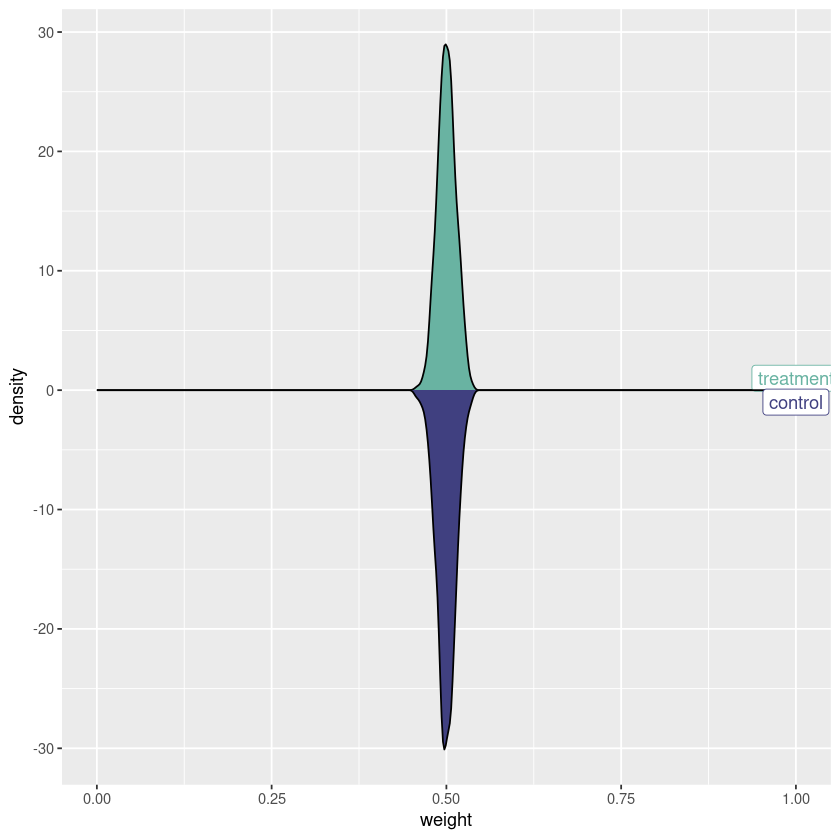

In [38]:
mirror_plot(tc_same, model_tc_same)

## Distributions differ only in mean

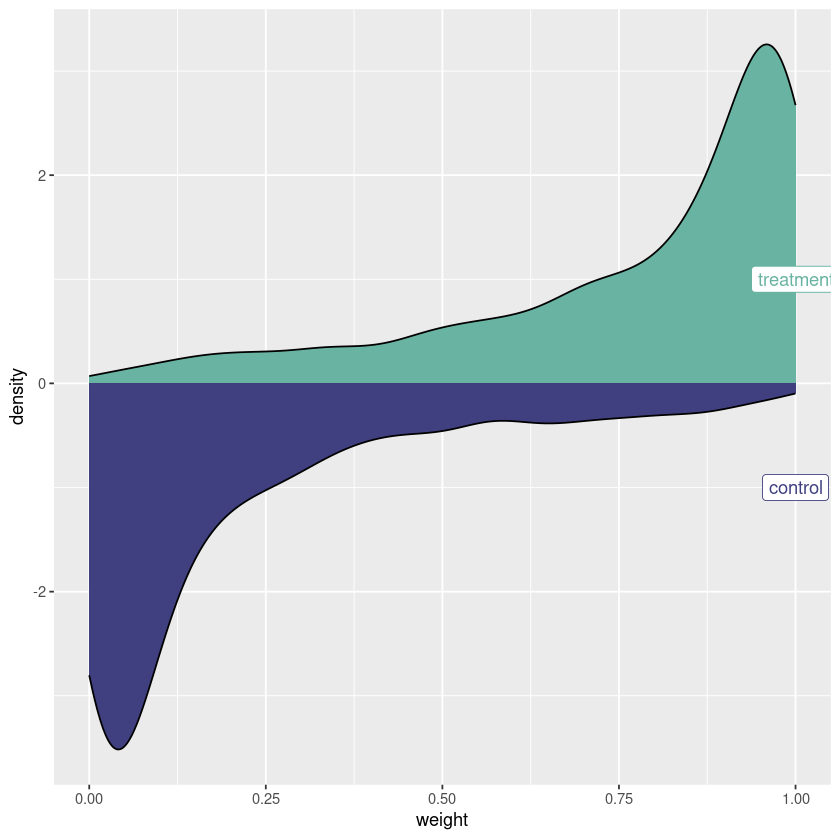

In [40]:
tc_diff_means <- data.table(x=c(rnorm(N, 0, 1), rnorm(N, 2, 1)),
                                treatment=c(rep(FALSE, N), rep(TRUE, N)))
model_diff_means <- SumStat(treatment ~ x, data=tc_diff_means)
mirror_plot(tc_diff_means, model_diff_means)

## Distributions differ only in variance

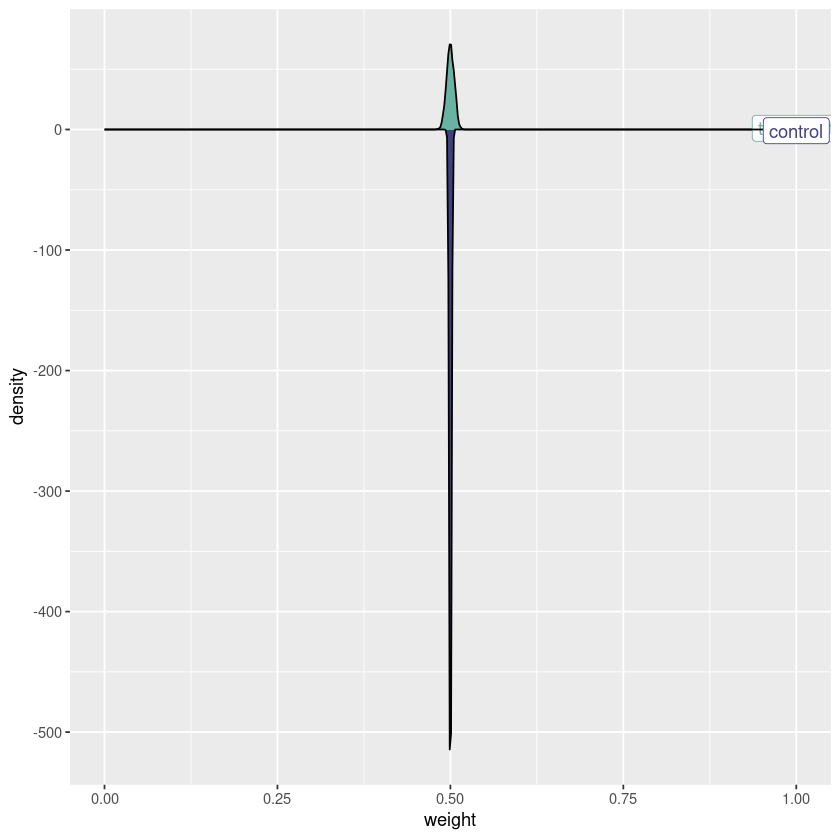

In [41]:
tc_diff_vars <- data.table(x=c(rnorm(N, 0, 1), rnorm(N, 0, 4)),
                                treatment=c(rep(FALSE, N), rep(TRUE, N)))
model_diff_vars <- SumStat(treatment ~ x, data=tc_diff_vars)
mirror_plot(tc_diff_vars, model_diff_vars)

## inflation at one end
Here we try something that variance itself can't give us. We artificially inflate with a large number of values that are most exclusive to the control group than the treatment group.

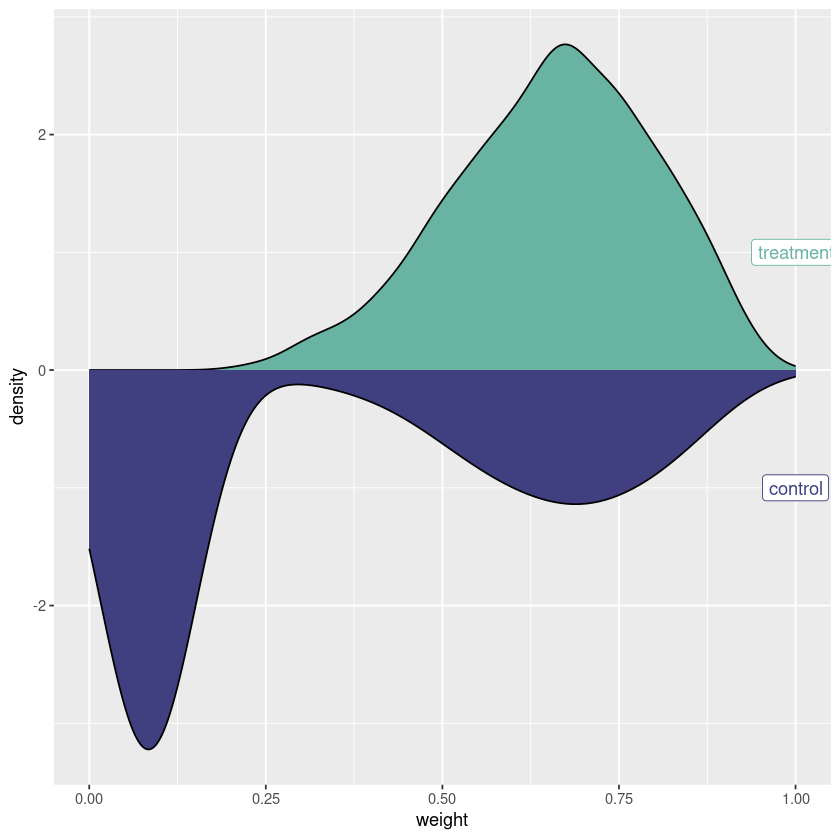

In [42]:
tc_inflation <- data.table(x=c(rpois(N, 20), rpois(N, 20)),
                                treatment=c(rep(FALSE, N), rep(TRUE, N)))
tc_inflation[0:(N/20), x := 0]
tc_inflation[N:(N - N/2), x := 0]
model_inflation <- SumStat(treatment ~ x, data=tc_inflation)
mirror_plot(tc_inflation, model_inflation)

In [46]:
tc_inflation[, weight := model_inflation$propensity[, 2]]

hist(tc_inflation[treatment==FALSE]$weight, breaks=20, plot=FALSE)

$breaks
 [1] 0.05 0.10 0.15 0.20 0.25 0.30 0.35 0.40 0.45 0.50 0.55 0.60 0.65 0.70 0.75
[16] 0.80 0.85 0.90 0.95

$counts
 [1] 551   0   0   0   0  11   5  24  19  32  37  80  39  78  55  36  28   5

$density
 [1] 11.02  0.00  0.00  0.00  0.00  0.22  0.10  0.48  0.38  0.64  0.74  1.60
[13]  0.78  1.56  1.10  0.72  0.56  0.10

$mids
 [1] 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525 0.575 0.625
[13] 0.675 0.725 0.775 0.825 0.875 0.925

$xname
[1] "tc_inflation[treatment == FALSE]$weight"

$equidist
[1] TRUE

attr(,"class")
[1] "histogram"

# Bibliography
[1] [Angrist, J. D., & Pischke, J.-S. (2008). Mostly harmless econometrics. Princeton University Press.](https://jonnyphillips.github.io/FLS6415/Class_3/Angrist%20&%20Pischke.pdf)

[2] [Steve Howard. Augmented Inverse Propensity Weighting for Randomized Experiments](https://www.stevehoward.org/blog/augmented-inverse-propensity-weighting-for-randomized-experiments.html)

[3] [Stefan Wager. STATS 361 notes](https://web.stanford.edu/~swager/stats361.pdf)

[4] Huzhang Mao, Liang Li, Tom Greene. Propensity score weighting analysis and treatment effect discovery (2019)

[5] Jared K Lunceford, Marie Davidian. Stratification and weighting via the propensity score in estimation of causal treatment effects: a comparative study (2004)